In [1]:
import os, time, copy
from collections import OrderedDict
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as vmodels
import torchvision.datasets as vdatasets


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as patches
import matplotlib.font_manager as fm
path = '/Library/Fonts/NanumBarunGothicBold.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

from PIL import Image as pil_image

import numpy as np
from skimage.transform import resize
from skimage.measure import label, regionprops


torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
BATCH_SIZE = 4

In [3]:
class Resnet_GAP(nn.Module):
    def __init__(self, base_model, nb_classes):
        super(Resnet_GAP, self).__init__()

        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, nb_classes)
        
    def forward(self, inputs):
        features = self.feature_extractor(inputs)
        x = self.gap(features)
        x = self.fc(x.view(inputs.size()[0], -1))
        return x

In [4]:
base_model = vmodels.resnet50(pretrained=False)
net = Resnet_GAP(base_model, 5)
net.load_state_dict(torch.load("../weights/pred_fullyconv/cam/best_model_e19_val_acc0.93.pth.tar", map_location='cpu'))
# net.eval()
net.to(device)

Resnet_GAP(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

In [5]:
class _PropagationBase(object):
    def __init__(self, model, target_layer):
        super(_PropagationBase, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model.eval()
        self.image = None
        self.target_layer = target_layer

    def _encode_one_hot(self, idx_list):
        one_hot = torch.zeros(self.preds.size())
        for i, idx in enumerate(idx_list):
            one_hot[i, idx] = 1.0
        return one_hot.to(self.device)

    def forward(self, image):
        self.model.zero_grad()
        self.preds = self.model(image)
        self.probs = F.softmax(self.preds, dim=1)
        return self.preds

    def backward(self, idx):
        one_hot = self._encode_one_hot(idx)
        self.preds.backward(gradient=one_hot, retain_graph=True)
        
class GradCAM(_PropagationBase):
    def __init__(self, model, target_layer):
        super(GradCAM, self).__init__(model, target_layer)
        self.fmap = None
        self.grad = None
        self.is_valid = False

        def func_f(module, input, output):
            self.fmap = output.detach()

        def func_b(module, grad_in, grad_out):
            self.grad = grad_out[0].detach()

        for module in self.model.named_modules():
            if module[0] == self.target_layer:
                self.is_valid = True
                module[1].register_forward_hook(func_f)
                module[1].register_backward_hook(func_b)

        if not self.is_valid:
            raise ValueError('Invalid layer name: {}'.format(target_layer))


    def _compute_grad_weights(self, grads):
        grads = self._normalize(grads)
        return F.adaptive_avg_pool2d(grads, 1)

    def generate(self):
        
        normalized_grad = F.normalize(self.grad, p=2, dim=1, eps=1e-12)
        weight = F.adaptive_avg_pool2d(normalized_grad, 1)
        
        weighted_combination = (self.fmap * weight).sum(dim=1)
        relued = torch.clamp(weighted_combination, min=0.0)
        
        min_values = relued.min(2, keepdim=True)[0].min(1, keepdim=True)[0]
        max_values = relued.max(2, keepdim=True)[0].max(1, keepdim=True)[0]
        gcam = ((relued - min_values) / max_values).cpu().numpy()
        
        
        return gcam

In [6]:
gradcam = GradCAM(net, 'feature_extractor.7.2')

In [51]:
# img_path = "samples/ahn1.JPG"
# cls = 0

In [7]:
# pil_image.open(img_path)

In [8]:
test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

cls2name = {0: '안철수', 1: '홍준표', 2:'문재인', 3:'심상정', 4:'유승민'}
cls2color = {0: 'green', 1: 'red', 2:'blue', 3:'yellow', 4:'teal'}

In [54]:
# img_path = paths[0]

# img = pil_image.open(img_path)
# img_array = np.asarray(img)[:, :, :3]
# n_H, n_W, n_C = img_array.shape

# to_feed = copy.deepcopy(img_array)
# inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
# inp_tensor = inp_tensor.to(device)

# net(inp_tensor)

tensor([[ 3.2776, -1.9184,  0.3554, -0.5731, -0.4931]])

In [9]:
# run_inference(paths[0], False)

In [24]:
def run_inference(img_path, is_heatmap, save=False, save_dir=None):
    img = pil_image.open(img_path)
    img_array = np.asarray(img)[:, :, :3]
    n_H, n_W, n_C = img_array.shape
    
    to_feed = copy.deepcopy(img_array)
    inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
    inp_tensor = inp_tensor.to(device)
    
    output = gradcam.forward(inp_tensor)
    softmax_output = F.softmax(output, dim=1)
    print(softmax_output)
    thres_output = ((softmax_output.detach() >= 0.4).numpy()[0])
    extracted_labels = np.where(thres_output > 0)[0].tolist()
    print(extracted_labels)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img_array)
#     ax.axis("off")
    
    if len(extracted_labels) > 0:
        
        for cls in extracted_labels:
            
            gradcam.backward([cls])
            gcam = gradcam.generate()
            
            canvas = resize(gcam[0], (n_H, n_W))
            
            if is_heatmap:
                ax.imshow(canvas, cmap='jet', alpha=0.5)
            else:
                labeled = label(canvas > 0.5)
                props = regionprops(labeled)
                
                rects = []
                print(props)
                for p in props:
                    ys, xs, ye, xe = p.bbox
                    w = xe - xs
                    h = ye - ys
                    
                    if w * h > 3000:
                        
                        rect = patches.Rectangle((xs, ys), w, h, linewidth=3, edgecolor=cls2color[cls], facecolor='none', alpha=0.75)
                        rects.append(rect)
                        ax.text(x=xs + 5, y=ys + 23, s=cls2name[cls], fontproperties=fontprop, color=cls2color[cls])

                for r in rects:
                    ax.add_patch(r)
                    
    
    if save:
        fname = os.path.basename(img_path)
        full_path = os.path.join(save_dir, fname)
        fig.savefig(full_path, bbox_inches='tight')
        print("saved - {}".format(full_path))
    else:
        plt.show()

tensor([[ 0.1296,  0.1102,  0.1580,  0.0230,  0.5792]])
[4]


/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[<skimage.measure._regionprops._RegionProperties object at 0x1c1acf7710>, <skimage.measure._regionprops._RegionProperties object at 0x1c1acf7748>]


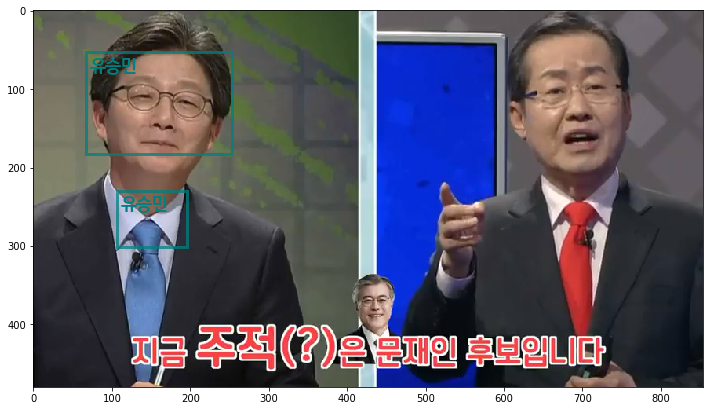

In [25]:
# run_inference("samples/moon3.jpg", is_heatmap=False, save=False, save_dir='video_res')
run_inference("../datasets/presidential_debate_frames_v2/frame040.jpg", is_heatmap=False, save=False, save_dir=None)

In [26]:
paths = glob("samples/*.jpg")

tensor([[ 0.9061,  0.0050,  0.0488,  0.0193,  0.0209]])
[0]


/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[<skimage.measure._regionprops._RegionProperties object at 0x1c938effd0>, <skimage.measure._regionprops._RegionProperties object at 0x1c938efba8>]


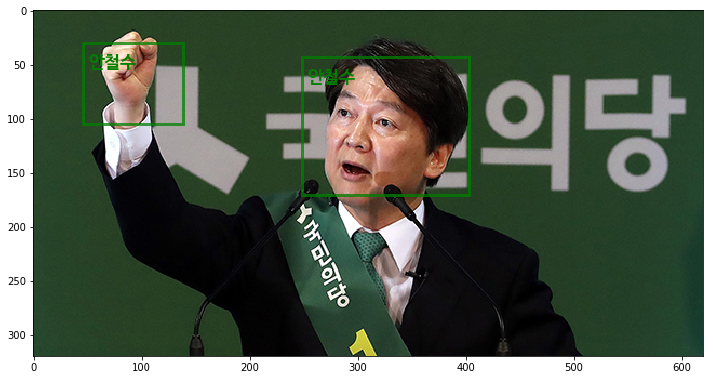

tensor([[ 0.9184,  0.0033,  0.0327,  0.0288,  0.0169]])
[0]
[<skimage.measure._regionprops._RegionProperties object at 0x1c7ed0b0f0>, <skimage.measure._regionprops._RegionProperties object at 0x1c7ed0b128>]


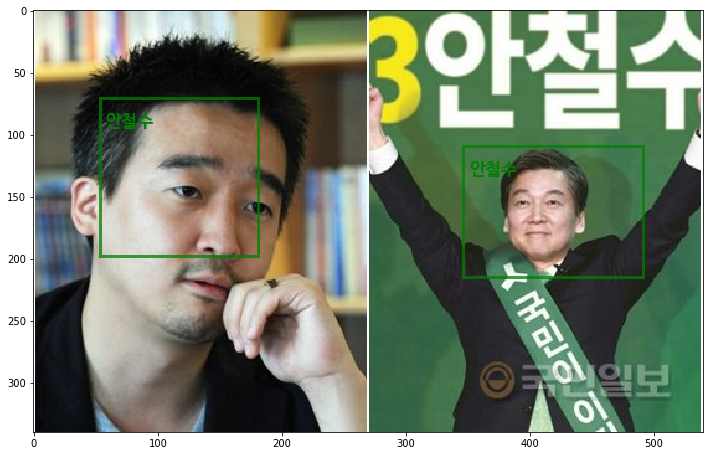

tensor([[ 0.9125,  0.0016,  0.0556,  0.0009,  0.0294]])
[0]
[<skimage.measure._regionprops._RegionProperties object at 0x1c93894c88>, <skimage.measure._regionprops._RegionProperties object at 0x1c93894668>]


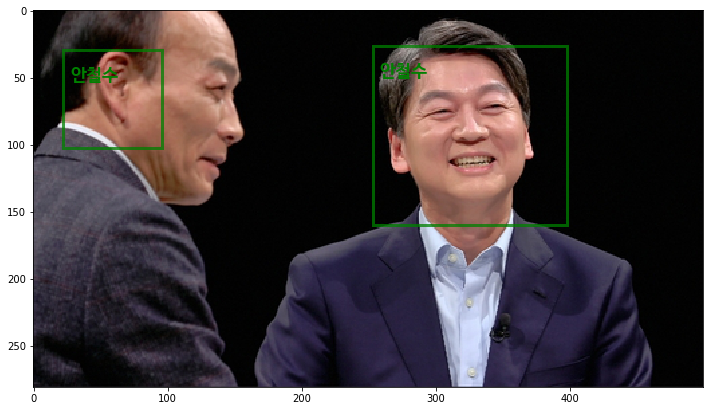

tensor([[ 0.2800,  0.1961,  0.2531,  0.0395,  0.2313]])
[]


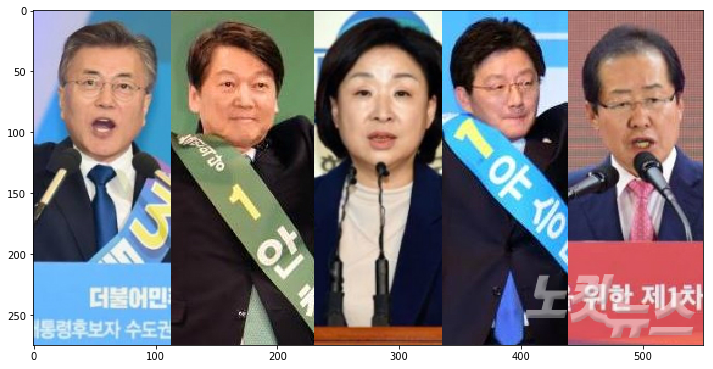

tensor([[ 0.2277,  0.0570,  0.1205,  0.0669,  0.5279]])
[4]


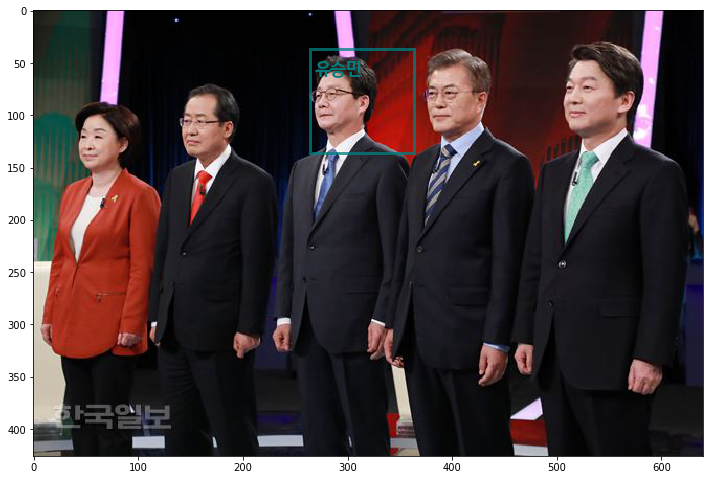

tensor([[ 0.0337,  0.0162,  0.8018,  0.0029,  0.1454]])
[2]
[<skimage.measure._regionprops._RegionProperties object at 0x1c1ac9b898>, <skimage.measure._regionprops._RegionProperties object at 0x1c1ac9b8d0>, <skimage.measure._regionprops._RegionProperties object at 0x1c1ac9b908>]


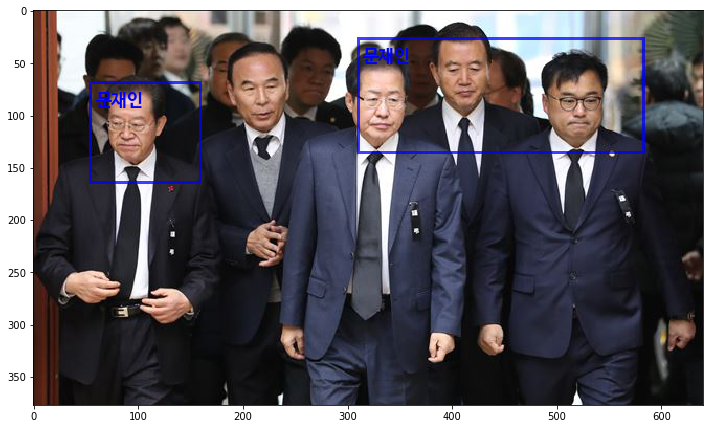

tensor([[ 0.1112,  0.5059,  0.1935,  0.0361,  0.1533]])
[1]


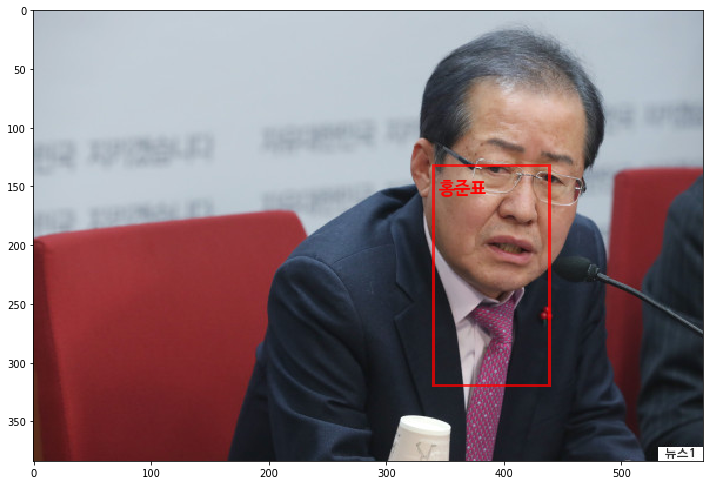

tensor([[ 0.2109,  0.3440,  0.0712,  0.0403,  0.3335]])
[]


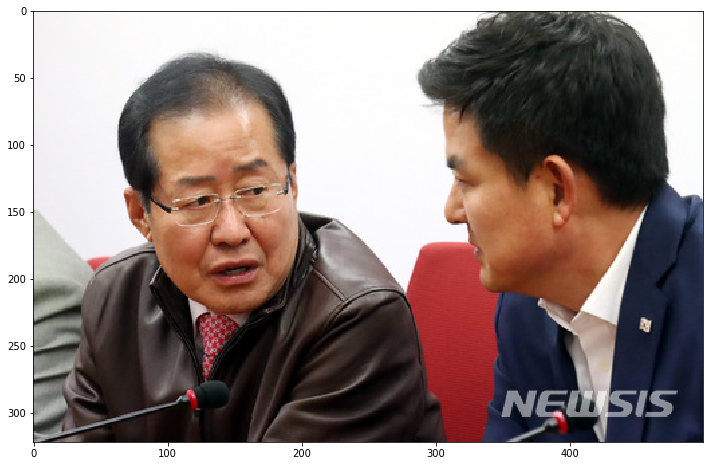

tensor([[ 0.1845,  0.0086,  0.7339,  0.0143,  0.0587]])
[2]


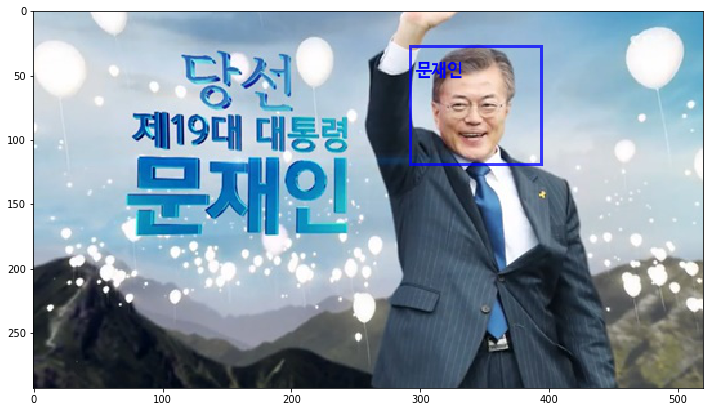

tensor([[ 0.1211,  0.1574,  0.5175,  0.0353,  0.1687]])
[2]


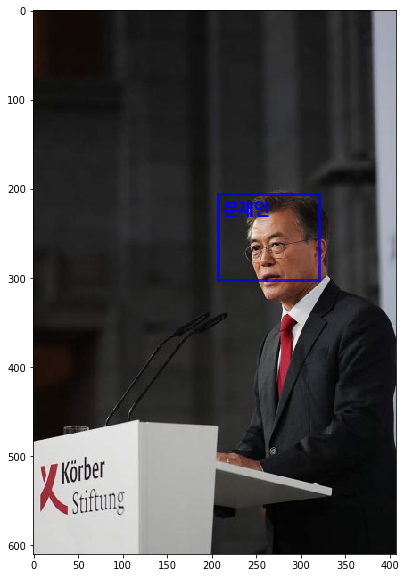

tensor([[ 0.1395,  0.0217,  0.0564,  0.7024,  0.0800]])
[3]
[<skimage.measure._regionprops._RegionProperties object at 0x1ccc6bfc18>, <skimage.measure._regionprops._RegionProperties object at 0x1ccc6bfe48>, <skimage.measure._regionprops._RegionProperties object at 0x1ccc6bfd68>]


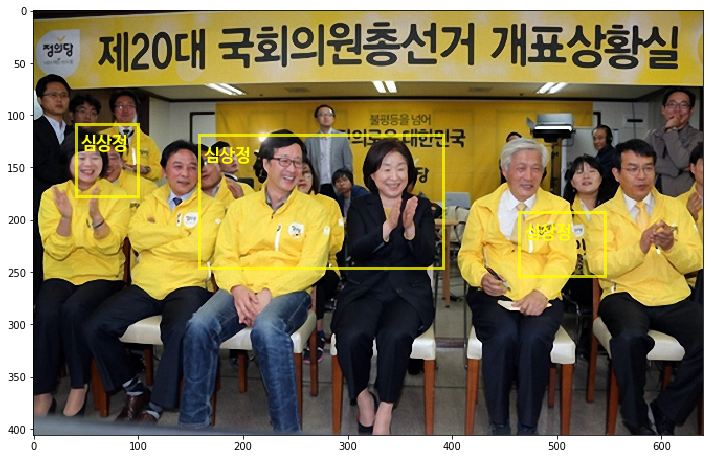

tensor([[ 0.0471,  0.0054,  0.0255,  0.8820,  0.0401]])
[3]
[<skimage.measure._regionprops._RegionProperties object at 0x1ccc6b64a8>, <skimage.measure._regionprops._RegionProperties object at 0x1ccc6b6438>]


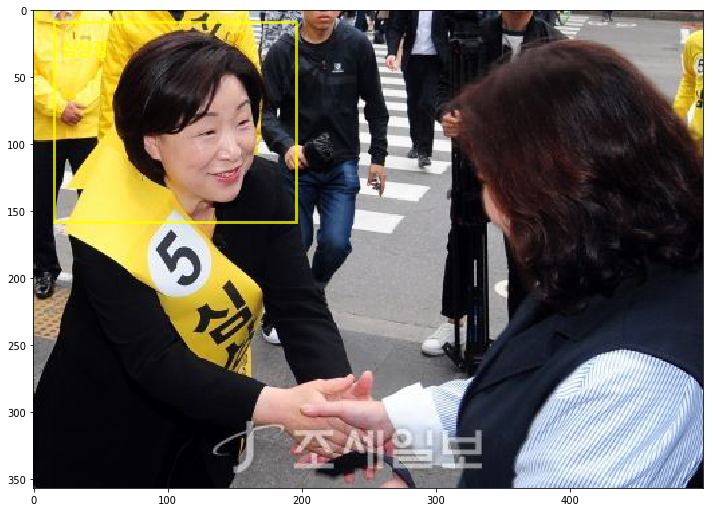

tensor([[ 0.1148,  0.0118,  0.0836,  0.7169,  0.0729]])
[3]
[<skimage.measure._regionprops._RegionProperties object at 0x1d0e9a4be0>, <skimage.measure._regionprops._RegionProperties object at 0x1d0e9a4b00>]


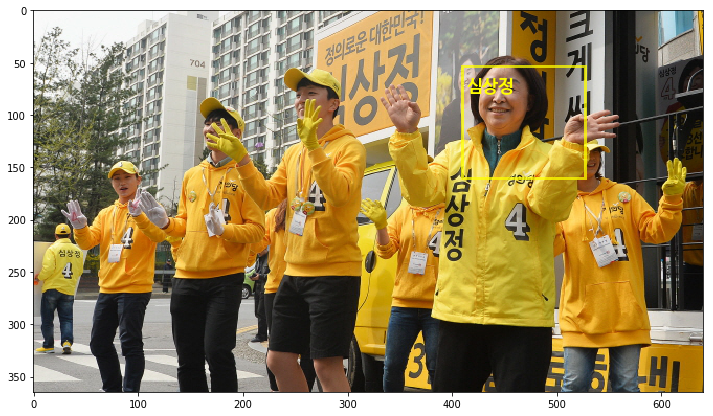

tensor([[ 0.0537,  0.0343,  0.0317,  0.0028,  0.8775]])
[4]


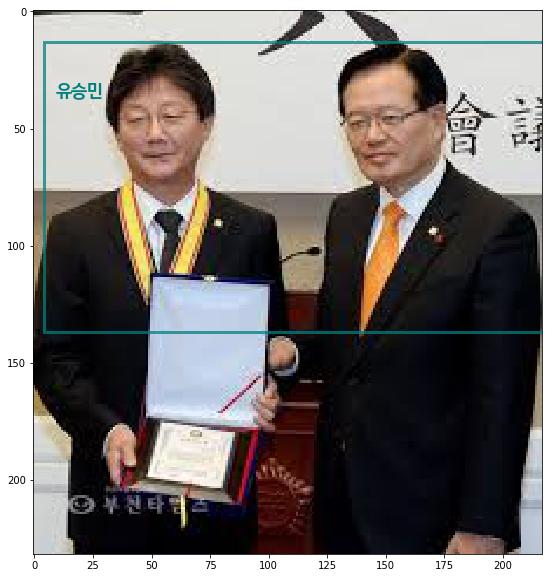

tensor([[ 0.1669,  0.0191,  0.4420,  0.0251,  0.3470]])
[2]


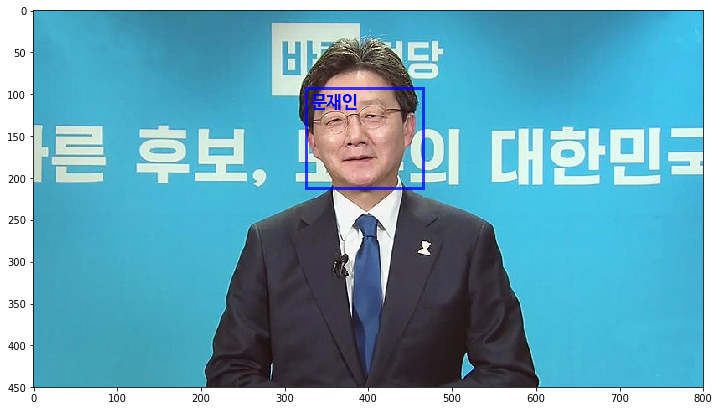

tensor([[ 0.4638,  0.0246,  0.0169,  0.0047,  0.4899]])
[0, 4]
[<skimage.measure._regionprops._RegionProperties object at 0x1c938fcda0>, <skimage.measure._regionprops._RegionProperties object at 0x1c938fc470>]


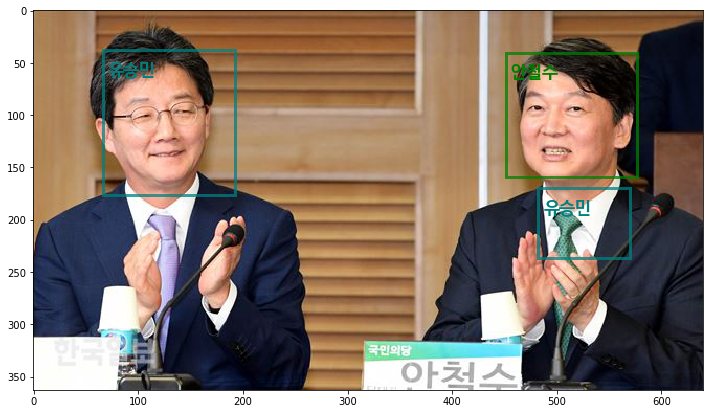

In [27]:
for p in paths:
    run_inference(p, is_heatmap=False, save=False, save_dir=None)

In [19]:
def run_cam(img_path, cls):

    img = pil_image.open(img_path)
    img_array = (np.asarray(img)[:, :, :3] / 255.).astype(float)
    n_H, n_W, n_C = img_array.shape
    
    img_array = resize(img_array, (int(n_H * 1), int(n_W * 1)))
    n_H, n_W, n_C = img_array.shape
    
    to_feed = copy.deepcopy(img_array)

    inp_tensor = normalize(torch.from_numpy(to_feed.transpose(2, 0, 1))).unsqueeze(0).float()
    inp_tensor = inp_tensor.to(device)

    preds = gradcam.forward(inp_tensor)
    print(preds)
    gradcam.backward([cls])
    gradcams = gradcam.generate()
    
    plt.imshow(img_array)
    plt.imshow(resize(gradcams[0], (n_H, n_W)), cmap='jet', alpha=0.5)
    plt.axis("off")
    plt.show()

/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 0.9061,  0.0050,  0.0488,  0.0193,  0.0209]])


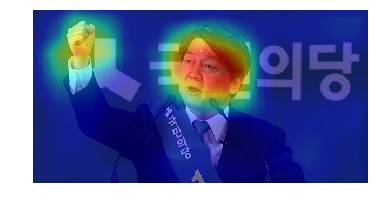

In [20]:
run_cam('samples/ahn1.jpg', 0)

/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 0.9184,  0.0033,  0.0327,  0.0288,  0.0169]])


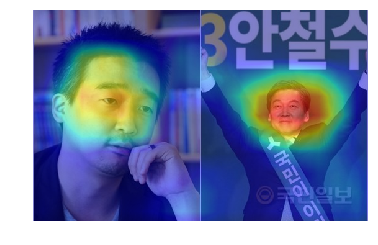

In [21]:
run_cam('samples/ahn2.jpg', 0)

/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 0.9125,  0.0016,  0.0556,  0.0009,  0.0294]])


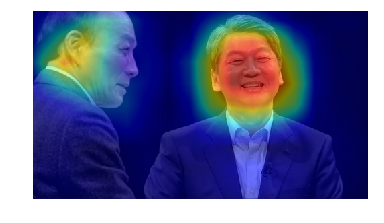

In [22]:
run_cam('samples/ahn3.jpg', 0)

/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 0.2632,  0.1060,  0.3291,  0.0309,  0.2707]])


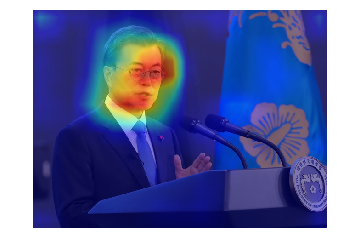

In [23]:
run_cam('samples/moon.jpg', 2)

/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 0.1845,  0.0086,  0.7339,  0.0143,  0.0587]])


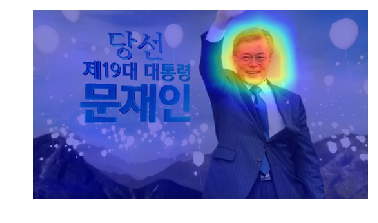

In [24]:
run_cam('samples/moon2.jpg', 2)

/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 0.0337,  0.0162,  0.8018,  0.0029,  0.1454]])


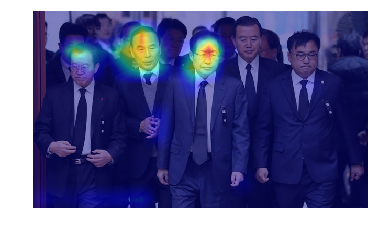

In [25]:
run_cam('samples/hong1.jpg', 1)

/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 0.1112,  0.5059,  0.1935,  0.0361,  0.1533]])


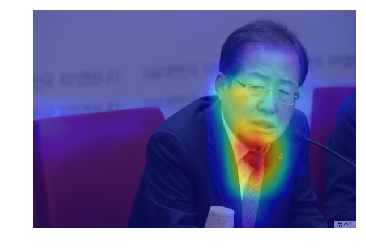

In [26]:
run_cam('samples/hong2.jpg', 1)

/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/junkwhinger/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


tensor([[ 0.2109,  0.3440,  0.0712,  0.0403,  0.3335]])


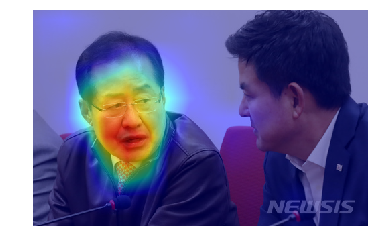

In [27]:
run_cam('samples/hong3.jpg', 1)